# Bayesian optimization

https://arxiv.org/pdf/1807.02811.pdf



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports, loads and Train/test split
---

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn-v0_8')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

In [5]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

truth - [1]
fake - [0]


In [6]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1590
Max len title: 13


In [7]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [8]:
embed_mat = np.zeros((50000,300))
for i, e in model.key_to_index.items():
    embed_mat[e] = model[i]

**Tran/valid/test split**

In [9]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [10]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [11]:
train_fit = [np.asarray(X_train_title.tolist()),
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()),
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()),
             np.asarray(X_test_content.tolist())]

In [12]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

In [16]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.0 MB/s eta 0:00:00


In [17]:
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed
# from tensorflow import set_random_seed

import tensorflow as tf

import os

# Finding optimal hyperparameters for the CNN

In [18]:
space  = [Real(1e-3, 0.4, name='learning rate'),
          Real(1e-3, 0.4, name='momentum'),
          Real(1e-3, 0.4, name='dropout1'),
          Real(1e-3, 0.4, name='dropout2'),
          Integer(5,15, name='filters1Title'),
          Integer(25,60, name='denseTitle'),
          Integer(5,15, name='filtersContent'),
          Integer(25,60, name='denseContent') ]

In [ ]:
@use_named_args(space)
def cnn_model(**params):

    x_train = train_fit
    y_train2 = np.array(y_train.tolist())

    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())

    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible
    seed(50)
    tf.random.set_seed(50)
    k.backend.clear_session()



    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000,
                             weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = k.layers.Conv1D(filters = params['filters1Title'], kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(params['denseTitle'], activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000,
                             weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = k.layers.Conv1D(filters = params['filtersContent'], kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 6, name='Pool1Content')(x2)

    x2 = k.layers.Conv1D(filters = 80, kernel_size = 8, strides = 4, activation='relu', name='Conv2Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 2, name='Pool2Content')(x2)

    x2 = k.layers.Flatten()(x2)
    x2 = k.layers.Dense(params['denseContent'], activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(params['dropout2'])(x)
    out = k.layers.Dense(1, activation='sigmoid')(x)


    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(k.optimizers.SGD(learning_rate=params['learning rate'], momentum=params['momentum']), loss='binary_crossentropy', metrics=['acc'])

    out = model.fit(x=x_train, y=y_train2, batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)],
                    validation_data=(x_valid, y_valid2))


    #Evaluation

    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [ ]:
r = skopt.gp_minimize(cnn_model, n_random_starts=3, n_calls=5, dimensions=space)


Epoch 1/20


E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'content_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 205s 440ms/step - acc: 0.6989 - loss: 1.6697 - val_acc: 0.8916 - val_loss: 1.0344
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 192s 426ms/step - acc: 0.9076 - loss: 0.9161 - val_acc: 0.9228 - val_loss: 0.6720
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 189s 419ms/step - acc: 0.9266 - loss: 0.6229 - val_acc: 0.9288 - val_loss: 0.4844
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - acc: 0.9291 - loss: 0.4836
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 203s 445ms/step - acc: 0.8425 - loss: 0.9949 - val_acc: 0.9203 - val_loss: 0.2250
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 192s 426ms/step - acc: 0.9368 - loss: 0.1783 - val_acc: 0.9425 - val_loss: 0.1558
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 190s 421ms/step - acc: 0.9504 - loss: 0.1466 - val_acc: 0.9429 - val_loss: 0.1698
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - acc: 0.9436 - loss: 0.1677
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 200s 437ms/step - acc: 0.8423 - loss: 0.9949 - val_acc: 0.9130 - val_loss: 0.2460
Epoch 2/2

E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'content_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 197s 430ms/step - acc: 0.8560 - loss: 0.7059 - val_acc: 0.9262 - val_loss: 0.1862
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 201s 445ms/step - acc: 0.9388 - loss: 0.1665 - val_acc: 0.9269 - val_loss: 0.1941
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 219s 485ms/step - acc: 0.9554 - loss: 0.1437 - val_acc: 0.9321 - val_loss: 0.2195
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - acc: 0.9315 - loss: 0.2219
Epoch 1/20


E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'content_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 206s 453ms/step - acc: 0.8414 - loss: 0.9248 - val_acc: 0.9262 - val_loss: 0.2040
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 208s 461ms/step - acc: 0.9360 - loss: 0.1760 - val_acc: 0.9392 - val_loss: 0.1658
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 202s 447ms/step - acc: 0.9454 - loss: 0.1595 - val_acc: 0.9446 - val_loss: 0.1601
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - acc: 0.9457 - loss: 0.1590


We can access the parameters with which the minimum is obtained in the loss function (maximum in our case)

In [ ]:
print("PARAMETERS: {}  RESULT {}".format(r.x, r.fun))

PARAMETERS: [0.26538360261750116, 0.0010154798309881946, 0.057072435925511, 0.20925672956753552, 13, 29, 12, 52]  RESULT -0.9456478357315063


As we see, with these parameters an accuracy of 0.81 is obtained in the validation set.

<Axes: >

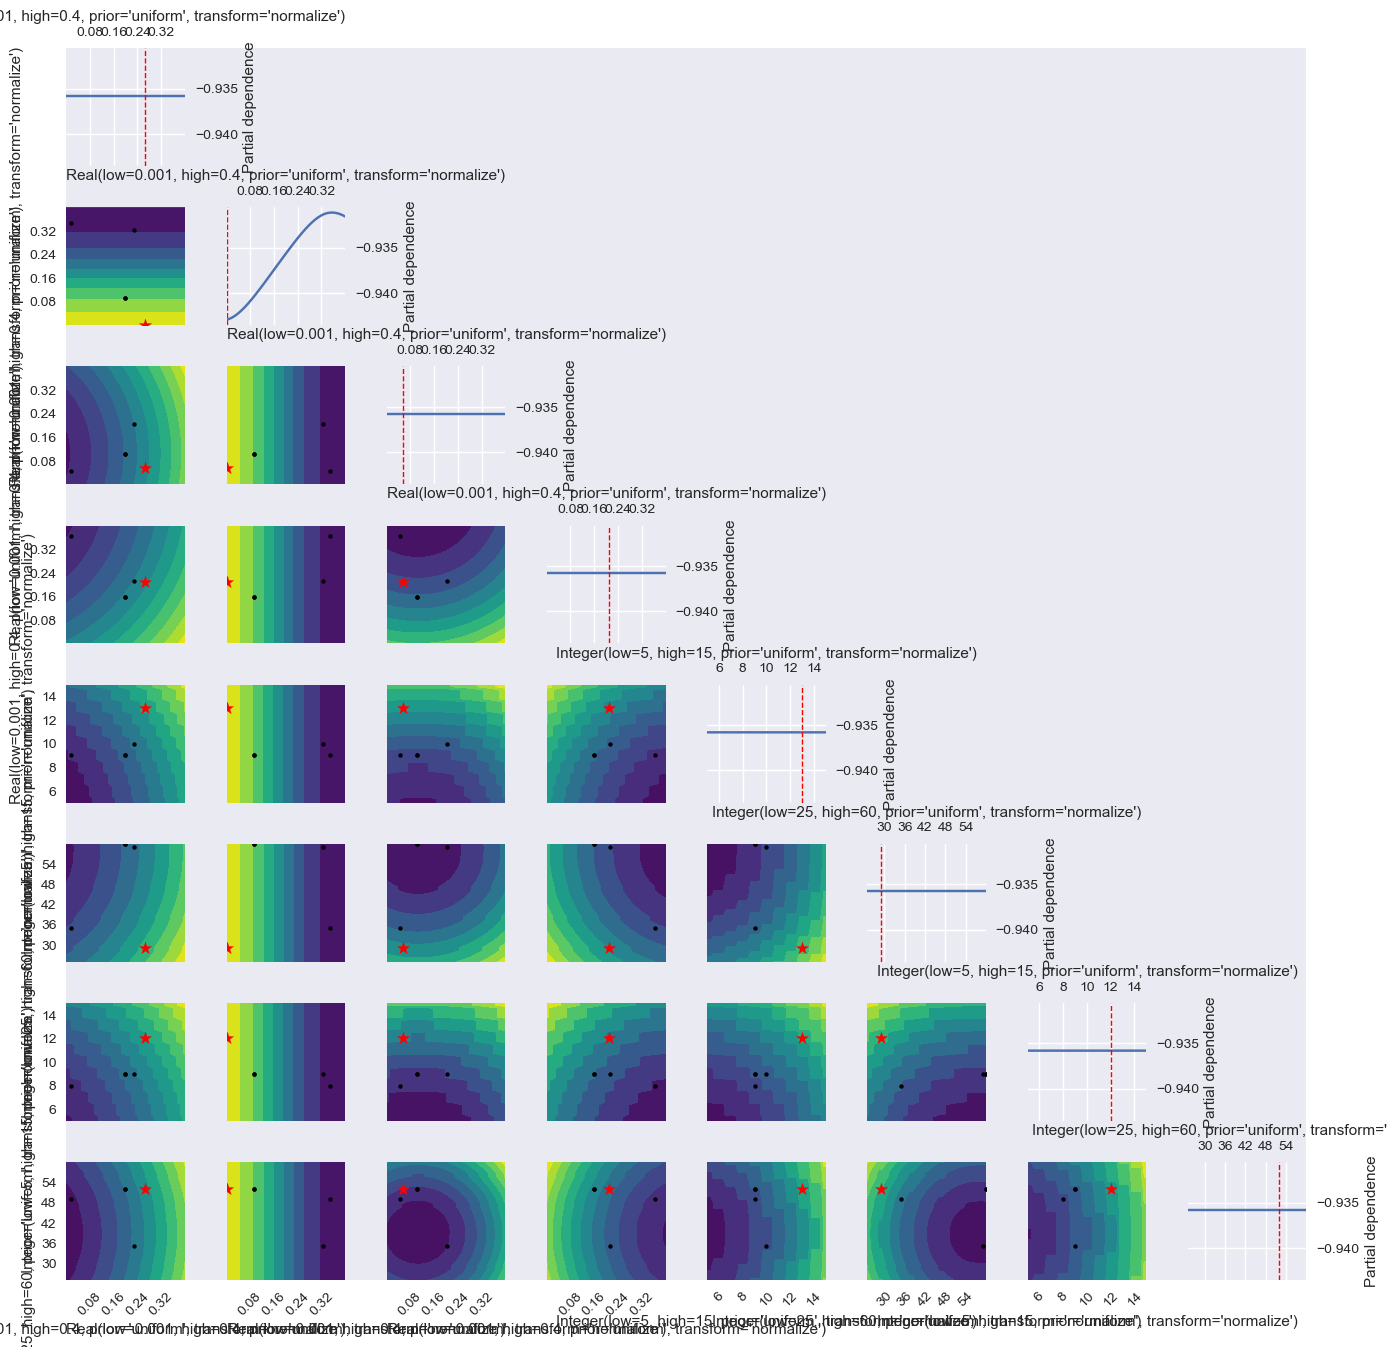

In [ ]:
plot_objective(r, dimensions=space)

In [ ]:
print("Params")
r.x_iters

Params


[[0.016496640567012732,
  0.34743288689728796,
  0.04558841241842605,
  0.3645137239587689,
  9,
  35,
  8,
  49],
 [0.1983460565696706,
  0.09200515867528518,
  0.10293409557912736,
  0.15913563397938804,
  9,
  60,
  9,
  52],
 [0.1983460565696706,
  0.09200515867528518,
  0.10293409557912736,
  0.15913563397938804,
  9,
  60,
  9,
  52],
 [0.22909274323780696,
  0.3245653584964726,
  0.20337725865566103,
  0.2122684191918501,
  10,
  59,
  9,
  35],
 [0.26538360261750116,
  0.0010154798309881946,
  0.057072435925511,
  0.20925672956753552,
  13,
  29,
  12,
  52]]

In [ ]:
print("Values")
r.func_vals

Values


array([-0.92891973, -0.94414514, -0.93654662, -0.93090445, -0.94564784])

# Find optimal hyperparameters for LSTM

In [22]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.1, name='momentum'),
          Real(0.1, 0.3, name='dropout1'),
          Integer(50,100, name='dense1'),
          Integer(20,50, name='dense2'),
          Integer(20,100, name='lstmTitle'),
          Integer(50,300, name='lstmContent')]


@use_named_args(space)
def lstm_model(**params):
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())

    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())

    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    # Reproducible weights
    seed(50)
    tf.random.set_seed(50)
    k.backend.clear_session()

    # input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000,
                           weights=[embed_mat], trainable=False)(title_input)
    x = k.layers.Bidirectional(k.layers.LSTM(params['lstmTitle']))(inp)

    # input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000,
                            weights=[embed_mat], trainable=False)(content_input)
    x2 = k.layers.Bidirectional(k.layers.LSTM(params['lstmContent']))(inp2)

    # Merge
    x = k.layers.concatenate([x, x2])

    # Common part
    x = k.layers.Dense(params['dense1'], activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(params['dense2'], activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)

    # Changed output to match CNN model (single unit with sigmoid)
    out = k.layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    # Compile model with momentum optimizer and binary crossentropy
    optimizer = k.optimizers.SGD(learning_rate=params['lr'], momentum=params['momentum'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Train the model - keeping the same structure as CNN
    out = model.fit(x=x_train, y=y_train2,
                   batch_size=128, epochs=20,
                   callbacks=[k.callbacks.EarlyStopping(monitor='val_acc',
                                                      patience=2,
                                                      min_delta=0.1)],
                   validation_data=(x_valid, y_valid2))

    # Evaluation
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1]  # Maximize accuracy

In [23]:
r = skopt.gp_minimize(lstm_model, n_random_starts=3, n_calls=5, dimensions=space)

Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 312s 676ms/step - acc: 0.8055 - loss: 0.4726 - val_acc: 0.9049 - val_loss: 0.2192
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 320s 681ms/step - acc: 0.9084 - loss: 0.2150 - val_acc: 0.9151 - val_loss: 0.1926
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 306s 678ms/step - acc: 0.9180 - loss: 0.1932 - val_acc: 0.9155 - val_loss: 0.1874
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 91s 82ms/step - acc: 0.9136 - loss: 0.1893
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 190s 414ms/step - acc: 0.8424 - loss: 0.3458 - val_acc: 0.9051 - val_loss: 0.2356
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 203s 416ms/step - acc: 0.9194 - loss: 0.1828 - val_acc: 0.9210 - val_loss: 0.1844
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 219s 454ms/step - acc: 0.9279 - loss: 0.1641 - val_acc: 0.9209 - val_loss: 0.1851
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 62s 56ms/step - acc: 0.9192 - loss: 0.1854
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 188s 410ms/step - acc: 0.8501 - loss: 0.3392 - val_acc: 0.9046 - val_loss: 0.244

In [24]:
print("PARAMETERS (LR/Optimizer): {}  RESULT {}".format(r.x, r.fun))

PARAMETERS (LR/Optimizer): [0.23097138708141426, 0.001, 0.14630023637797968, 59, 31, 79, 157]  RESULT -0.9227388501167297


<Axes: >

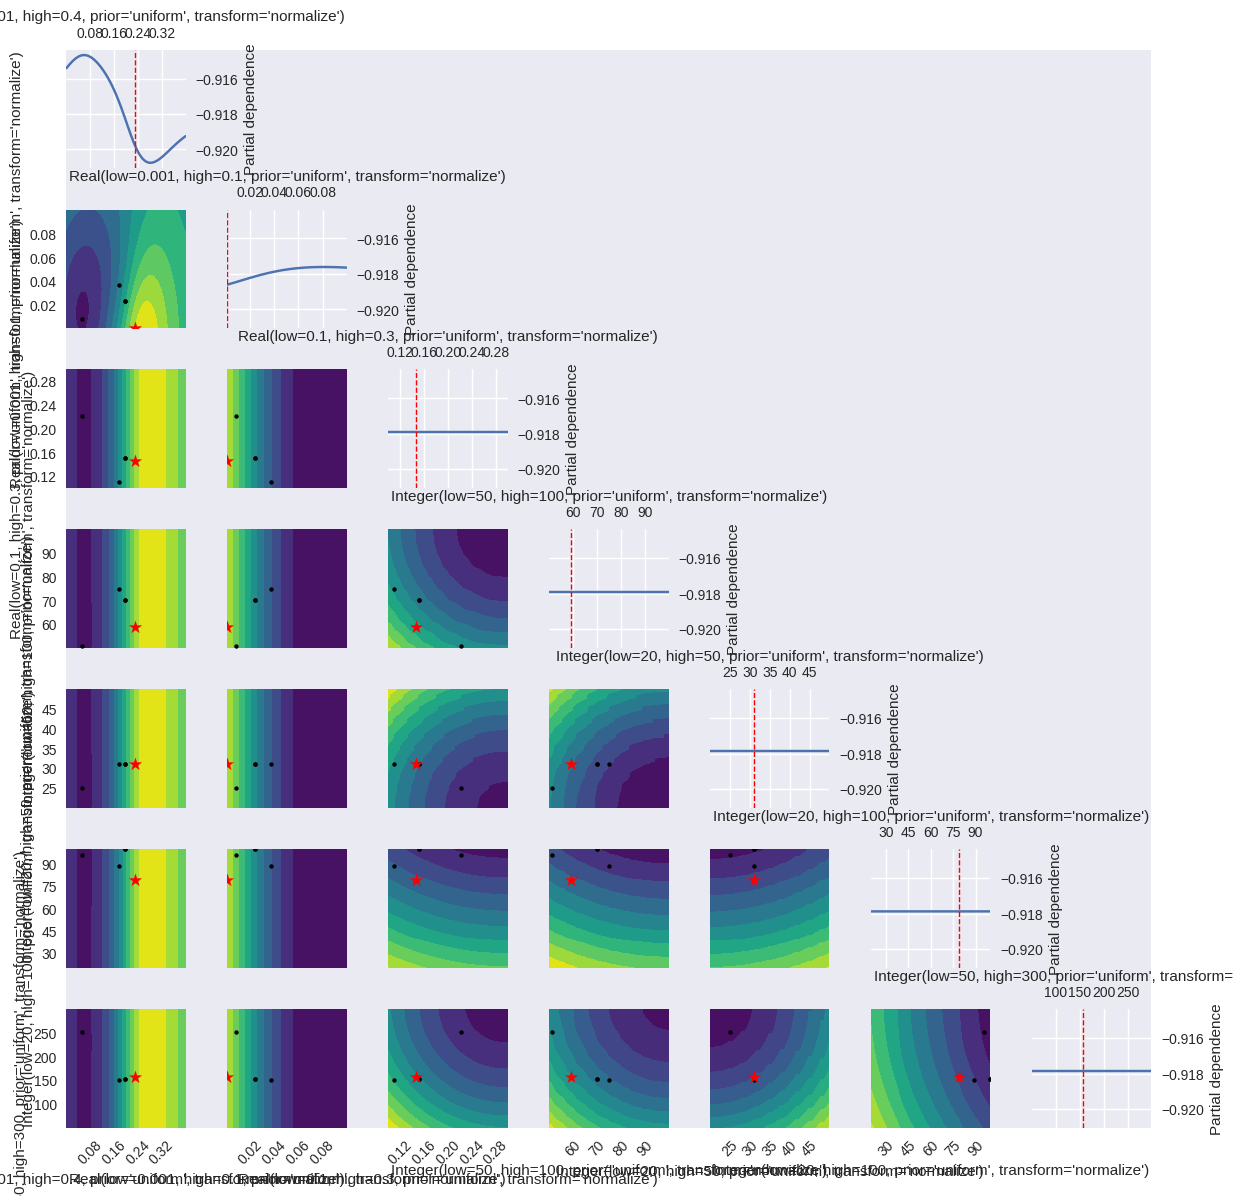

In [25]:
plot_objective(r, dimensions=space)